In [4]:
from pyAudioAnalysis import ShortTermFeatures as aF
from pyAudioAnalysis import audioBasicIO as aIO 
import numpy as np 
import plotly.graph_objs as go 
import plotly
import IPython
import os
import pickle 

/afs/cs.stanford.edu/u/prabhat8/dfs/cs224s/lib/python3.7/site-packages/pydub/utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [5]:
data_path = '/dfs/user/prabhat8/CS224S/gad'

In [6]:
# play the initial and the generated files in notebook:
IPython.display.display(IPython.display.Audio(f"{data_path}/z1ZG7KErZsOmaVFrHNlh.wav"))

In [7]:
wav2c = {}

In [3]:
len(wav2c)

NameError: name 'wav2c' is not defined

In [32]:

# with open(os.path.join(data_path, 'wav2vec_feats.pkl'), 'wb') as f:
#     pickle.dump(wav2c, f)

In [8]:
with open(os.path.join(data_path, 'wav2vec_feats.pkl'), 'rb') as f:
    wav2c = pickle.load(f)
    
len(wav2c)

2257

In [9]:
import fairseq

In [30]:
import torch
import fairseq
from fairseq.models.wav2vec import Wav2VecModel
import tqdm
import glob 
import librosa
import math

cp_path = '/dfs/user/prabhat8/CS224S/models/wav2vec_large.pt'
cp = torch.load(cp_path, map_location='cpu')
model = Wav2VecModel.build_model(cp['args'], task=None)
model.load_state_dict(cp['model'])
model.eval()

with torch.no_grad():
    for wav in tqdm.tqdm(glob.glob(f"{data_path}/*.wav")):
        if os.path.basename(wav) in wav2c:
            continue
        audio_input, sr = librosa.load(wav, sr=16000)
        try:
            wav_input_16khz = torch.tensor(audio_input).unsqueeze(0)
            if len(audio_input) > 16000*60:
                vals = torch.chunk(wav_input_16khz, round(len(audio_input) / (16000*60)), dim=-1)
#                 if len(vals) > 1:
#                     print(len(vals), len(audio_input) / (16000*60))
            else:
                vals = [wav_input_16khz]
            z = []
            c = []
            for val in vals:
                zi = model.feature_extractor(val)
                c.append(model.feature_aggregator(zi).squeeze())
                z.append(zi.squeeze())
            z, c = torch.cat(z, dim=-1), torch.cat(c, dim=-1)
#             if len(vals)> 1:
#                 print(z.size(), c.size(), len(audio_input))
            wav2c[os.path.basename(wav)] = (z, c)
        except Exception as e:
            print(e, wav, len(audio_input))
# x = model(wav_input_16khz)
# x

100%|██████████| 2257/2257 [1:41:17<00:00,  2.69s/it]  


In [10]:
import pandas as pd
labels = pd.read_csv(os.path.join(data_path, 'data.csv'))
labels = labels.drop_duplicates('filename').set_index('filename')
labels.shape

(2257, 5)

In [11]:
labels.sample(2)

,dataset,user,score,bucketed_score,duration
filename,,,,,
6021b7e7d3ab592b663519faquestions6021b7e7d3ab592b663519e8responses60227f1c69a46ecc4dee9c86.wav,Phonic6,6021b7e7d3ab592b663519faquestions6021b7e7d3ab5...,2.0,0,62.890667
responses6001797d955d181478ef1c58.wav,Phonic1,responses6001797d955d181478ef1c58,0.0,0,40.874667


In [12]:
labels['feats_z'] = labels.index.map(lambda x: wav2c[x][0].mean(dim=-1))
labels['feats_c'] = labels.index.map(lambda x: wav2c[x][1].mean(dim=-1))
labels['anxiety'] = labels['bucketed_score'] > 0

In [13]:
labels['feats_z'].iloc[0].shape

torch.Size([512])

In [14]:
labels.bucketed_score.value_counts()

0    1162
1     529
2     335
3     231
Name: bucketed_score, dtype: int64

In [15]:
labels.anxiety.value_counts()

False    1162
True     1095
Name: anxiety, dtype: int64

In [16]:
df['split'] = df['anxiety'].map(lambda x: 'train' if )

SyntaxError: invalid syntax (<ipython-input-16-c6a8a7c9ff04>, line 1)

In [17]:
feats, y = np.stack(labels.feats_z.values), labels['anxiety']
feats.shape, y.shape

((2257, 512), (2257,))

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [19]:
train_idx, test_idx = train_test_split(np.arange(len(feats)), test_size=0.15, random_state=24)
train_idx, valid_idx = train_test_split(train_idx, test_size=0.15, random_state=24)

In [20]:
split = [""]*len(feats)
for i in train_idx:
    split[i] = 'train'
for i in valid_idx:
    split[i] = 'valid'
for i in test_idx:
    split[i] = 'test'
    
labels['split'] = split
labels.split.value_counts()

train    1630
test      339
valid     288
Name: split, dtype: int64

In [21]:
labels.columns

Index(['dataset', 'user', 'score', 'bucketed_score', 'duration', 'feats_z',
       'feats_c', 'anxiety', 'split'],
      dtype='object')

In [38]:
labels[['dataset', 'user', 'score', 'bucketed_score', 'duration', 'anxiety', 'split']].to_pickle(os.path.join(data_path, 'data_split.pkl'))

In [22]:
X_train, y_train = np.stack(labels[labels.split == 'train'].feats_z.values), labels[labels.split == 'train']['anxiety']
X_valid, y_valid = np.stack(labels[labels.split == 'valid'].feats_z.values), labels[labels.split == 'valid']['anxiety']
X_test, y_test = np.stack(labels[labels.split == 'test'].feats_z.values), labels[labels.split == 'test']['anxiety']

In [23]:
print(len(X_train), len(X_valid), len(X_test))

1630 288 339


In [24]:
y_train.sum(),  (~y_train).sum(), y_train.shape[0], \
y_valid.sum(),  (~y_valid).sum(), y_valid.shape[0], \
y_test.sum(),  (~y_test).sum(), y_test.shape[0],
y.sum(),  (~y).sum(), y.shape[0]

(1095, 1162, 2257)

In [25]:
from sklearn.metrics import roc_auc_score
def analyze_clf(clf, y_prob=None):
    if y_prob is None:
        clf = clf.fit(X_train, y_train) 
        y_pred = clf.predict(X_valid)
        if not hasattr(clf, 'predict_proba'):
            y_prob = clf.decision_function(X_valid)
        else:
            y_prob = clf.predict_proba(X_valid)[:, 1]
    else:
        y_pred = y_prob > 0.5
    print(y_pred.shape)
    from sklearn.metrics import confusion_matrix,  classification_report
    y_true = y_valid
    print(confusion_matrix(y_true, y_pred))
    print(classification_report(y_true, y_pred))
    print(roc_auc_score(y_true=y_true, y_score=y_prob))

In [26]:
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier(strategy="uniform")
analyze_clf(dummy_clf)


(288,)
[[79 70]
 [63 76]]
              precision    recall  f1-score   support

       False       0.56      0.53      0.54       149
        True       0.52      0.55      0.53       139

    accuracy                           0.54       288
   macro avg       0.54      0.54      0.54       288
weighted avg       0.54      0.54      0.54       288

0.5


In [27]:
clf = make_pipeline(StandardScaler(), LogisticRegression(random_state=0, max_iter=300, penalty='l1', solver='liblinear'))
analyze_clf(clf)

(288,)
[[90 59]
 [57 82]]
              precision    recall  f1-score   support

       False       0.61      0.60      0.61       149
        True       0.58      0.59      0.59       139

    accuracy                           0.60       288
   macro avg       0.60      0.60      0.60       288
weighted avg       0.60      0.60      0.60       288

0.6382598619091305


In [28]:
clf = make_pipeline(StandardScaler(), LogisticRegression(random_state=0, max_iter=500))
analyze_clf(clf)

(288,)
[[91 58]
 [60 79]]
              precision    recall  f1-score   support

       False       0.60      0.61      0.61       149
        True       0.58      0.57      0.57       139

    accuracy                           0.59       288
   macro avg       0.59      0.59      0.59       288
weighted avg       0.59      0.59      0.59       288

0.6291825599922747


In [29]:
clf = make_pipeline(StandardScaler(), SVC(C=10))

analyze_clf(clf)

(288,)
[[92 57]
 [45 94]]
              precision    recall  f1-score   support

       False       0.67      0.62      0.64       149
        True       0.62      0.68      0.65       139

    accuracy                           0.65       288
   macro avg       0.65      0.65      0.65       288
weighted avg       0.65      0.65      0.65       288

0.7157066293274107


In [30]:
from sklearn.metrics import confusion_matrix,  classification_report
clf = make_pipeline(StandardScaler(), SVC(C=10))
clf.fit(np.concatenate([X_train, X_valid]), np.concatenate([y_train, y_valid]))
y_true = y_test
y_pred = clf.predict(X_test)
y_prob = clf.decision_function(X_test)
print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred))
print(roc_auc_score(y_true=y_true, y_score=y_prob))

[[122  51]
 [ 65 101]]
              precision    recall  f1-score   support

       False       0.65      0.71      0.68       173
        True       0.66      0.61      0.64       166

    accuracy                           0.66       339
   macro avg       0.66      0.66      0.66       339
weighted avg       0.66      0.66      0.66       339

0.689393411797479


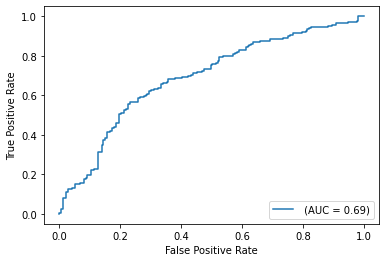

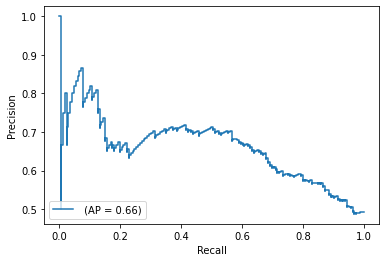

In [284]:
from sklearn import datasets, metrics, model_selection, svm
metrics.plot_roc_curve(clf, X_test, y_test, pos_label=None, name='')  
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.savefig('roc_curve.pdf')
metrics.plot_precision_recall_curve(clf, X_test, y_test, pos_label=None, name='')  
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.savefig('prc_curve.pdf')